In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split


In [4]:
# Creating the data from the "Chars74K" data set on my drive
classes = 10
images = []
labels = []

for i in range(0, classes):
    imgList = os.listdir('/content/drive/MyDrive/Data_set/Data/'+str(i))
    for j in imgList:
        currentImg = cv2.imread('/content/drive/MyDrive/Data_set/Data/'+str(i)+'/'+str(j))
        currentImg = cv2.resize(currentImg, (28, 28))
        images.append(currentImg)
        labels.append(i)

print(len(images))
print(len(labels))

10160
10160


In [5]:
images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)

(10160, 28, 28, 3)
(10160,)


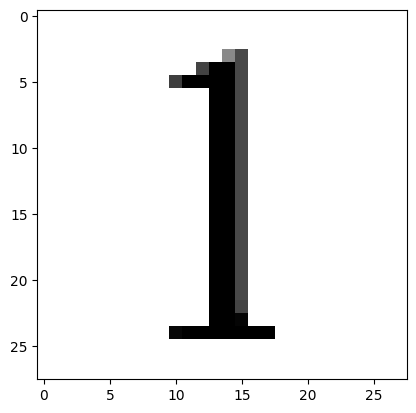

In [7]:
plt.imshow(images[1234])

In [8]:
# Splitting the 10160 data points into train and testing data sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)
print(train_images.shape)
print(test_images.shape)

(8128, 28, 28, 3)
(2032, 28, 28, 3)


In [9]:
#Splitting the 8128 data points into train and validation data sets
train_images,  val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2)
print(train_images.shape)
print(val_images.shape)

(6502, 28, 28, 3)
(1626, 28, 28, 3)


In [10]:
#Preprocessing the data
def preProcess(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.equalizeHist(img)
    x,img=cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img=img/255
    return img

train_images = np.array(list(map(preProcess, train_images)))
test_images = np.array(list(map(preProcess, test_images)))
val_images = np.array(list(map(preProcess, val_images)))
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(6502, 28, 28)
(2032, 28, 28)
(1626, 28, 28)


In [11]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
val_images = val_images.reshape(val_images.shape[0], 28, 28, 1)
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(6502, 28, 28, 1)
(2032, 28, 28, 1)
(1626, 28, 28, 1)


In [13]:
#Defining call back
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.995):
            print("\nReached 99.5% accuracy so cancelling training!")
            self.model.stop_training = True

In [14]:
#Creating CNN Model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28, 28, 1),  activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Conv2D(64, (3,3),  activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Conv2D(64, (3,3),  activation="relu"),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation="relu"),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(10,activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

In [15]:
#Image Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)

In [20]:
#Training the model
callbacks = myCallback()
history = model.fit(datagen.flow(train_images, train_labels),
                              epochs = 45, validation_data = (val_images, val_labels), callbacks = [callbacks])

Epoch 1/45
204/204 [==============================] - 3s 14ms/step - loss: 0.1084 - accuracy: 0.9648 - val_loss: 0.0175 - val_accuracy: 0.9938
Epoch 2/45
204/204 [==============================] - 4s 19ms/step - loss: 0.1138 - accuracy: 0.9651 - val_loss: 0.0191 - val_accuracy: 0.9945
Epoch 3/45
204/204 [==============================] - 3s 13ms/step - loss: 0.1090 - accuracy: 0.9652 - val_loss: 0.0193 - val_accuracy: 0.9932
Epoch 4/45
204/204 [==============================] - 3s 13ms/step - loss: 0.1049 - accuracy: 0.9662 - val_loss: 0.0178 - val_accuracy: 0.9945
Epoch 5/45
202/204 [============================>.] - ETA: 0s - loss: 0.1110 - accuracy: 0.9660
Reached 99.5% accuracy so cancelling training!
204/204 [==============================] - 4s 19ms/step - loss: 0.1119 - accuracy: 0.9659 - val_loss: 0.0196 - val_accuracy: 0.9951


In [21]:
#Evaluating model using test set
score = model.evaluate(test_images, test_labels, verbose=1)
print('Test Score : ', score[0])
print('Test Accuracy : ', score[1])

64/64 [==============================] - 0s 4ms/step - loss: 0.0151 - accuracy: 0.9951
Test Score :  0.0150699932128191
Test Accuracy :  0.9950787425041199


In [24]:
#Save the model
model.save('/content/drive/MyDrive/Trained Models/Dizit_rec')
model.save("/content/drive/MyDrive/Trained Models/Dizit_rec.h5")